# Malaria predictor: an image classification problem
# Training a Convolutional Neural Network with data augmentation

This notebook creates a convolutional neural network using Keras framework to classify images to predict when a cell is infected or not infected with Malaria. The image data was previouslly processed, stored in a numpy array and saved to disk. We will load this files to get the train and validation datasets. And to avoid overfitting we apply the data augmentation technique, it allow to train the model on much more images for a longer number of epochs 

### Loading the libraries and setting global variables

In [1]:
import matplotlib.pyplot as plt
import os
import numpy as np


In [2]:
#root folder
root_folder='..'

# Set the folder with the dataset or images
data_folder_name='Datasets/malaria_data'
DATA_PATH = os.path.abspath(os.path.join(root_folder, data_folder_name))

#Compressed file of numpy arrays of images
file_np_array="x_images_arrays.npz"
file_np_array_zip="x_images_arrays_zip_10000.npz"
labels_np_array="y_infected_labels_10000.npz"

#Full Dataset
#The Full Dataset are in the next variable
#file_np_array_zip="x_images_arrays_zip21765.npz"
#labels_np_array="y_infiltration_labels21765.npz"


### Load the images and labels as numpy arrays

In [4]:
# Load npz file containing image arrays
if file_np_array_zip!=None:
    x_npz = np.load(DATA_PATH+'/'+file_np_array_zip)
else:
    x_npz = np.load(DATA_PATH+'/'+file_np_array)
    
x = x_npz['arr_0']
# Load binary encoded labels for Lung Infiltrations: 0=Not_infiltration 1=Infiltration
y_npz = np.load(DATA_PATH+'/'+labels_np_array)
y = y_npz['arr_0']

In [6]:
x.shape
#x[0,0,0]
#y.shape
#x.max()

(10000, 128, 128, 3)

### Split the data in train, validation and test sets

In [7]:
from sklearn.model_selection import train_test_split

# First split the data in two sets, 80% for training, 20% for Val/Test)
X_train, X_valtest, y_train, y_valtest = train_test_split(x,y, test_size=0.2, random_state=1, stratify=y)

# Second split the 20% into validation and test sets
X_test, X_val, y_test, y_val = train_test_split(X_valtest, y_valtest, test_size=0.5, random_state=1, stratify=y_valtest)


Now, lets show the dimensions of our datasets

In [8]:
print('X_train n: ',len(X_train),' Shape: ',X_train.shape)
print('X_test n: ',len(X_test),' Shape: ',X_test.shape)
print('X_val n: ',len(X_val),' Shape: ',X_val.shape)
print('y_train n: ',y_train.shape)
print('y_test n: ',y_test.shape)
print('y_val n: ',y_val.shape)

X_train n:  8000  Shape:  (8000, 128, 128, 3)
X_test n:  1000  Shape:  (1000, 128, 128, 3)
X_val n:  1000  Shape:  (1000, 128, 128, 3)
y_train n:  (8000,)
y_test n:  (1000,)
y_val n:  (1000,)


### Create a keras model defining a CNN architecture

We set the parameters batch size and number of epochs and then create a model containing 3 convolutional + Maxpool layers and finally a fully-connected layer with 1 output, infected or not infected. 

In [10]:
#Define global variables
batch_size = 64
epochs = 3


In [9]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization

Using TensorFlow backend.


In [11]:
model = Sequential()
# Add a Convolutional layer, 32 kernels
model.add(Conv2D(32, kernel_size=(3, 3), input_shape=(128, 128, 3)))
#model.add(BatchNormalization())
model.add(Activation("relu"))
# Add a pooling layer of shape 2x2
model.add(MaxPooling2D(pool_size=(2, 2)))
# Add a Convolutional layer, 64 kernels
model.add(Conv2D(64, kernel_size=(3, 3)))
#model.add(BatchNormalization())
model.add(Activation("relu"))
# Add a pooling layer of shape 2x2
model.add(MaxPooling2D(pool_size=(2, 2)))
# Add a Convolutional layer, 128 kernels
model.add(Conv2D(128, kernel_size=(3, 3)))
#model.add(BatchNormalization())
model.add(Activation("relu"))

model.add(MaxPooling2D(pool_size=(2, 2)))
# Add a dropout layer for regularization
#Change in dropout keep_prob por rate, as 1- keeo:prob
model.add(Dropout(0.25))
model.add(Flatten())
# Add a FC layer, 128 inputs -> 1 output
model.add(Dense(128, activation='relu'))
# Add a dropout layer for regularization
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 126, 126, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 61, 61, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxP

## Train the model using Data augmentation on the datasets

In [13]:
# Set the number of samples to train
nb_train_samples = len(X_train)
# Set the number of samples to validate
nb_validation_samples = len(X_val)
# Set the epochs
epochs_gen=3

Then we create a Image data generator indicating some kind of transformation to apply to the images before training. Apply horizontal and vertical flipping, some rotations and width and height shifting.

In [14]:
from keras.preprocessing.image import ImageDataGenerator

# define data preparation
shift = 0.2
# Define the transformation on the train images
train_datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90,
                                  width_shift_range=shift, height_shift_range=shift)
# In the test set we do not apply any transformation to simulate a real inference scenario 
valtest_datagen = ImageDataGenerator()

#Will aply only a rescale o normalization
#train_datagen = ImageDataGenerator(rescale=1. / 255)
#valtest_datagen = ImageDataGenerator(rescale=1. / 255)


In [15]:
#Apply the transformation or data augmentation previously defined
train_generator = train_datagen.flow(np.array(X_train), y_train, batch_size=batch_size)
validation_generator = valtest_datagen.flow(np.array(X_val), y_val, batch_size=batch_size)
test_generator = valtest_datagen.flow(np.array(X_test), y_test, batch_size=batch_size)

In [16]:
#Train the model and save the parameters
history = model.fit_generator(
    train_generator, 
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs_gen,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size
)


Epoch 1/3
125/125 [==============================] - 240s 2s/step - loss: 0.3037 - acc: 0.8909 - val_loss: 0.2029 - val_acc: 0.9156
Epoch 2/3
125/125 [==============================] - 232s 2s/step - loss: 0.2698 - acc: 0.8985 - val_loss: 0.1855 - val_acc: 0.9295
Epoch 3/3
125/125 [==============================] - 236s 2s/step - loss: 0.2620 - acc: 0.9085 - val_loss: 0.1829 - val_acc: 0.9402


### Showing the results

In [26]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
print('Metrics: ',model.metrics_names)


Test loss: 0.20214661039918772
Test accuracy: 0.9512867647058824
Metrics:  ['loss', 'acc']
Log Loss X_test:  0.20214659127990292


In the next cells we plot some figures with the losses and accuracy on the different datasets and the confussion matrix 

In [ ]:
# Calculamos la log_loss para X_test
from sklearn.metrics import log_loss

Y_pred = model.predict_proba(X_test).astype('float64')
loss = log_loss(y_test, Y_pred, eps=1e-15)
print('Log Loss X_test: ',loss)

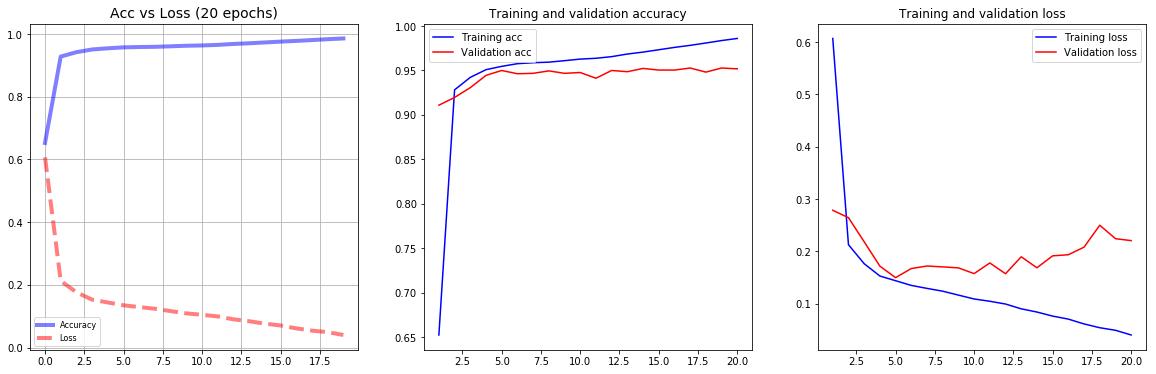

In [25]:
#plt.figure(figsize=(8, 15))
#plt.subplot(1,3,1)
fig = plt.figure(figsize=(20, 6))
ax = fig.add_subplot(131)
ax.set_title('Acc vs Loss ({} epochs)'.format(epochs), fontsize=14)
ax.plot(history.history['acc'], 'b-', label='Accuracy', lw=4, alpha=0.5)
ax.plot(history.history['loss'], 'r--', label='Loss', lw=4, alpha=0.5)
ax.legend(fontsize=8)
ax.grid(True)

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

ax=fig.add_subplot(132)
ax.plot(epochs, acc, 'blue', label='Training acc')
ax.plot(epochs, val_acc, 'red', label='Validation acc')
ax.set_title('Training and validation accuracy')
ax.legend()
#plt.figure()

#plt.subplot(1,3,2)
ax=fig.add_subplot(133)
ax.plot(epochs, loss, 'blue', label='Training loss')
ax.plot(epochs, val_loss, 'red', label='Validation loss')
ax.set_title('Training and validation loss')
ax.legend()
                 
plt.show()

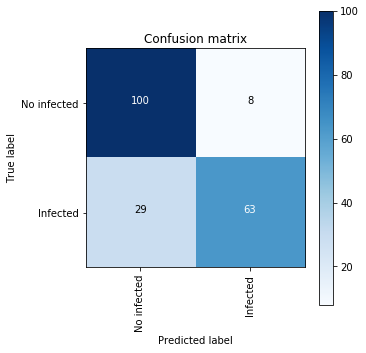

In [15]:
import sklearn
import itertools
from sklearn.metrics import confusion_matrix

dict_characters = {0: 'No infected', 1: 'Infected'}
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.figure(figsize = (4,4))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
a=X_train
b=y_train
c=X_test
d=y_test
Y_pred = model.predict_classes(c)
confusion_mtx = confusion_matrix(d, Y_pred) 
plot_confusion_matrix(confusion_mtx, classes = list(dict_characters.values()))

### Save the model to disk

In [24]:
# Save model and hyperparameters to disk

# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")


Saved model to disk
